In [2]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt('stabilityData')
data.shape

(101, 6)

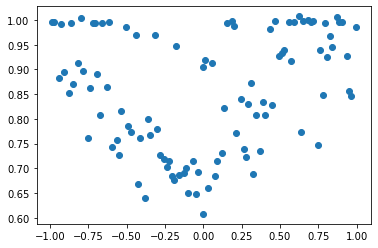

In [25]:
y=data[:,-1]
x=data[:,0]
plt.scatter(x/1e-3,y)
plt.show()

(array([ 1.,  0.,  2.,  2.,  1.,  4.,  4.,  1.,  6.,  4.,  2.,  3.,  5.,
         1.,  1.,  4.,  4.,  2.,  3.,  4.,  1.,  3.,  3.,  4.,  4.,  2.,
         0.,  3.,  9., 18.]),
 array([0.60765045, 0.62098871, 0.63432697, 0.64766523, 0.66100349,
        0.67434175, 0.68768001, 0.70101827, 0.71435653, 0.72769479,
        0.74103305, 0.75437131, 0.76770957, 0.78104783, 0.79438609,
        0.80772435, 0.82106261, 0.83440087, 0.84773913, 0.86107739,
        0.87441565, 0.88775391, 0.90109217, 0.91443043, 0.92776869,
        0.94110695, 0.95444521, 0.96778347, 0.98112173, 0.99445999,
        1.00779825]),
 <BarContainer object of 30 artists>)

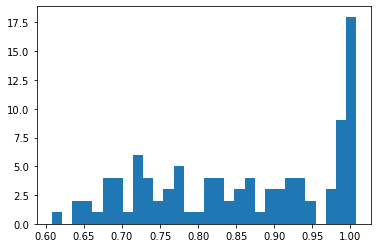

In [22]:
plt.hist(y,bins=30)